<a href="https://colab.research.google.com/github/iskra3138/GluonTS/blob/master/4_Synthetic_Data_Generation_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ref. https://gluon-ts.mxnet.io/examples/synthetic_data_generation_tutorial/tutorial.html

## 환경 구현

Colab에서 어떤 GPU가 할당되었는 지 확인

In [1]:
!nvidia-smi

Tue Apr 21 05:31:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

MXNET 설치 
- GluonTS는 Amazon이 2019년 공개한 Tool로서 MXNET을 backbone으로 사용
  - https://aws.amazon.com/blogs/machine-learning/creating-neural-time-series-models-with-gluon-time-series/

- 어떤 버전의 MXNET을 설치해야 하는 지는 아래 링크 참고
  - https://mxnet.apache.org/get_started/?platform=linux&language=python&processor=gpu&environ=pip&

In [2]:
# nvidia-smi로 CUDA Version 확인하고 해당되는 MXNET 설치
!pip install mxnet-cu101

     |████████████████████████████████| 710.5MB 26kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


colab에서 GluoTS Tutorial을 이용할 때 최신 pydantic package가 설치되면 아래 에러가 나오므로 1.4로 설치해줌
- TypeError: create_model() takes exactly 1 positional argument (0 given)


In [3]:
!pip install pydantic==1.4

     |████████████████████████████████| 7.5MB 23.1MB/s 


GluonTS를 설치함
- 설치가 완료되면 Restart Runtime Box를 클릭하여 Runtime을 재시작하고 Tutorial을 시작

In [4]:
!pip install gluonts

     |████████████████████████████████| 327kB 41.8MB/s 
     |████████████████████████████████| 235kB 54.6MB/s 
     |████████████████████████████████| 194kB 59.9MB/s 
     |████████████████████████████████| 10.4MB 38.6MB/s 
  Created wheel for ujson: filename=ujson-1.35-cp36-cp36m-linux_x86_64.whl size=68028 sha256=80b62bc5b2ecfdaacf97565a5c5a003f7b1275b55a781c73b8f0c461948aea21
  Stored in directory: /root/.cache/pip/wheels/28/77/e4/0311145b9c2e2f01470e744855131f9e34d6919687550f87d1
Successfully built ujson
ERROR: google-colab 1.0.0 has requirement pandas~=1.0.0; python_version >= "3.0", but you'll have pandas 0.25.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: python-dateutil 2.8.1
    Uninstalling python-dateutil-2.8.1:
      Successfully uninstalled python-dateutil-2.8.1
  Found existing installation: pandas 1.0.3
    Uninstalling pandas-1.0.3:
      Succ

# Synthetic Data Generation Tutorial

In [0]:
import json
from itertools import islice
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

In [0]:
from gluonts.dataset.artificial import recipe as rcp
from gluonts.core.serde import dump_code, load_code

In [0]:
# plotting utils

def plot_recipe(recipe, length):
    output_dict = rcp.evaluate(recipe, length)
    K = len(output_dict)
    lct = MultipleLocator(288)
    minor = AutoMinorLocator(12)

    fig, axs = plt.subplots(K, 1, figsize=(16, 2 * len(recipe)))
    for i, k in enumerate(output_dict):
        axs[i].xaxis.set_major_locator(lct)
        axs[i].xaxis.set_minor_locator(minor)
        axs[i].plot(output_dict[k])
        axs[i].grid()
        axs[i].set_ylabel(k)


def plot_examples(recipe, target, length, num, anomaly_indicator=None):
    fix, axs = plt.subplots(num, 1, figsize=(16, num * 2))
    for i in range(num):
        xx = rcp.evaluate(recipe, length)
        axs[i].plot(xx[target])
        axs[i].set_ylim(0, 1.1*np.max(xx[target]))
        axs[i].grid()
        if anomaly_indicator is not None:
            axs[i].fill_between(
                np.arange(len(xx[target])), 
                xx[anomaly_indicator] * 1.1*np.max(xx[target]), 
                np.zeros(len(xx[target])), 
                alpha=0.3,
                color="red")


def print_dicts(*dicts):
    for d in dicts:
        print("{")
        for k,v in d.items():
            print("\t", k, ": ", v)
        print("}\n")

## Recipes

Recipes are lists of `(name, expression)` tuples. The role of a recipe is to describe the generative process of a single time series. In order to do so, the `expression`s in the `(name, expression)` pairs are evaluated for each time series in the order given in the list to produce a `{name: value}` dictionary as output.

In [4]:
recipe = [
    ("myOutput1", 1.0),
    ("myOutput2", 42)
]

rcp.evaluate(recipe, length=5)

{'myOutput1': 1.0, 'myOutput2': 42}

### Expressions

Each `expression` can either be a Python value, a string (interpreted as a reference to previously defined `name`), or a special type of `Callable`, that is evaluated each time the recipe is evaluated.

In [5]:
recipe = [
    ("myOutput1", 1.0),
    ("myOutput2", "myOutput1")  # reference to previously defined name
]

rcp.evaluate(recipe, length=5)

{'myOutput1': 1.0, 'myOutput2': 1.0}

In [6]:
recipe = [
    ("myOutput1", rcp.RandomGaussian()),  # callable as expression
]

# multiple evaluations lead to different results, due to randomness
print_dicts(
    rcp.evaluate(recipe, length=5),
    rcp.evaluate(recipe, length=5),
)

{
	 myOutput1 :  [-0.76490833  1.89484781  1.2182063   1.42215259  0.0153073 ]
}

{
	 myOutput1 :  [-2.12114468  0.0263033   0.87544632 -0.87082733  0.67370906]
}



### Expressions with References

In [7]:
recipe = [
    ("stddev1", 2.0),
    ("stddev2", rcp.RandomUniform(low=0, high=1, shape=(1, ))),
    ("myOutput1", rcp.RandomGaussian(stddev="stddev1")),
    ("myOutput2", rcp.RandomGaussian(stddev="stddev2"))
]

# multiple evaluations lead to different results, due to randomness
print_dicts(
    rcp.evaluate(recipe, length=5),
    rcp.evaluate(recipe, length=5)
)

{
	 stddev1 :  2.0
	 stddev2 :  [0.71204916]
	 myOutput1 :  [-0.91696858  5.40023396 -2.13548066  1.25550301 -1.02936   ]
	 myOutput2 :  [-0.24228747  0.5448056  -1.30852564 -0.73822022  0.06858822]
}

{
	 stddev1 :  2.0
	 stddev2 :  [0.56021122]
	 myOutput1 :  [ 1.16762566  3.45795941 -3.23092192  1.13239666 -0.80740338]
	 myOutput2 :  [-0.30935767 -0.2310594  -0.13347016  0.14739844  0.55052091]
}



In [8]:
recipe = [
    ("random_out", rcp.RandomGaussian(shape=(1,))),
    ("fixed_out", np.random.randn(1))
]

# note that fixed_out stays the same; 
# it's evaluated only once when the recipe is created
print_dicts(
    rcp.evaluate(recipe, length=1),
    rcp.evaluate(recipe, length=1)
)

{
	 random_out :  [-0.48693908]
	 fixed_out :  [0.08952493]
}

{
	 random_out :  [0.11635459]
	 fixed_out :  [0.08952493]
}



### Length

Most operators in the `recipe` package have a `length` argument that is automatically passed when the expression is evaluated. The idea is that these recipes are used to generate fixed-length time series, and most operators produce
individual components of the time series that have the same length.

In [9]:
recipe = [
    ("random_gaussian", rcp.RandomGaussian()),
    ("constant_vec", rcp.ConstantVec(42))
]
     
print_dicts(
    rcp.evaluate(recipe, length=3),
    rcp.evaluate(recipe, length=5)
)

{
	 random_gaussian :  [-0.11976619  0.08455725  0.24285434]
	 constant_vec :  [42. 42. 42.]
}

{
	 random_gaussian :  [1.54371645 0.35437151 0.5036122  0.0958449  0.60208403]
	 constant_vec :  [42. 42. 42. 42. 42.]
}



### Operator Overloading

The `Callable` operators defined in the `recipe` package overload the basic arithmetic operations (addition, subtraction, multiplication, division).

In [10]:
recipe = [
    ("x1", 42 * rcp.ConstantVec(1)),
    ("x2", "x1" * rcp.RandomUniform()),
    ("x3", rcp.RandomGaussian() + rcp.RandomUniform()), 
    ("x4", rcp.Ref("x1") + "x2" + "x3")
]

rcp.evaluate(recipe, 3)

{'x1': array([42., 42., 42.]),
 'x2': array([13.55240476,  8.94312623,  2.70651814]),
 'x3': array([ 0.61122551,  0.01790675, -0.89588716]),
 'x4': array([56.16363027, 50.96103298, 43.81063098])}

### SerDe

Recipes composed of serializable / representable components can easily be serialized / deserialized.

In [11]:
dumped = dump_code(recipe)
print(dumped)

reconstructed = load_code(dumped)

rcp.evaluate(reconstructed, 3)

[["x1", gluonts.dataset.artificial.recipe.LiftedMul(left=42, right=gluonts.dataset.artificial.recipe.ConstantVec(constant=1))], ["x2", gluonts.dataset.artificial.recipe.LiftedMul(left="x1", right=gluonts.dataset.artificial.recipe.RandomUniform(high=1.0, low=0.0, shape=[0]))], ["x3", gluonts.dataset.artificial.recipe.LiftedAdd(left=gluonts.dataset.artificial.recipe.RandomGaussian(shape=[0], stddev=1.0), right=gluonts.dataset.artificial.recipe.RandomUniform(high=1.0, low=0.0, shape=[0]))], ["x4", gluonts.dataset.artificial.recipe.LiftedAdd(left=gluonts.dataset.artificial.recipe.LiftedAdd(left=gluonts.dataset.artificial.recipe.Ref(field_name="x1"), right="x2"), right="x3")]]


{'x1': array([42., 42., 42.]),
 'x2': array([10.69789133,  5.12947941, 10.05601109]),
 'x3': array([2.50233254, 1.4112407 , 0.52067238]),
 'x4': array([55.20022388, 48.54072011, 52.57668347])}

## Simple Examples

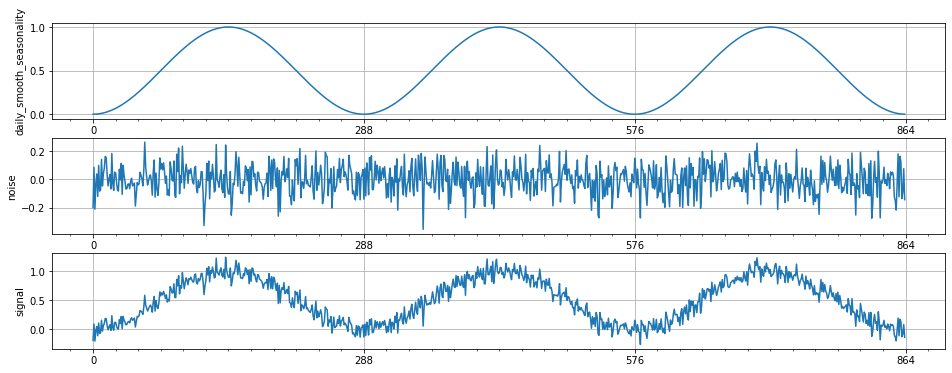

In [12]:
recipe = [
    ("daily_smooth_seasonality", rcp.SmoothSeasonality(period=288, phase=-72)),
    ("noise", rcp.RandomGaussian(stddev=0.1)),
    ("signal", rcp.Add(["daily_smooth_seasonality", "noise"]))
]

plot_recipe(recipe, 3 * 288)


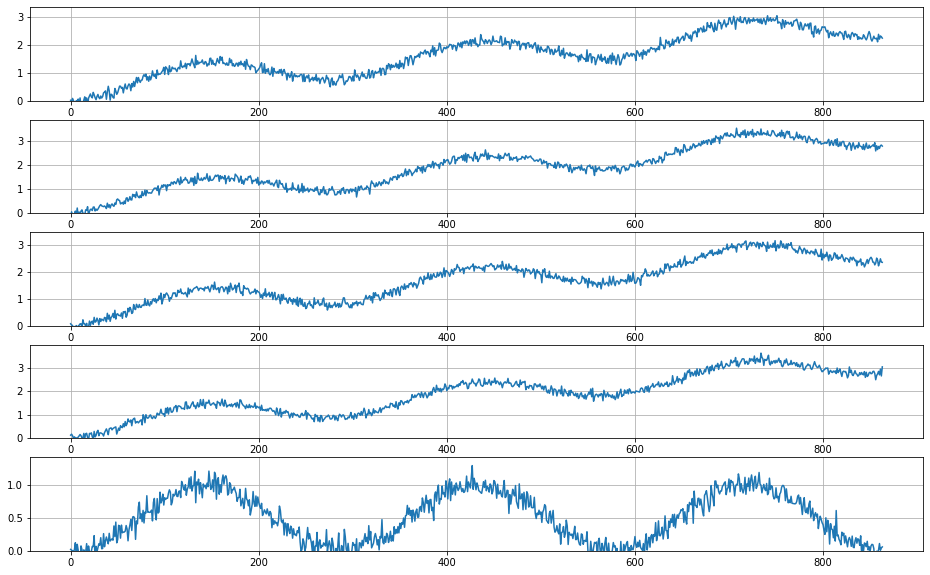

In [13]:
recipe = [
    ("slope", rcp.RandomUniform(low=0, high=3, shape=(1,))),
    ("trend", rcp.LinearTrend(slope="slope")),
    ("daily_smooth_seasonality", rcp.SmoothSeasonality(period=288, phase=-72)),
    ("noise", rcp.RandomGaussian(stddev=0.1)),
    ("signal", rcp.Add(["trend", "daily_smooth_seasonality", "noise"]))
]

plot_examples(recipe, "signal", 3 * 288, 5)

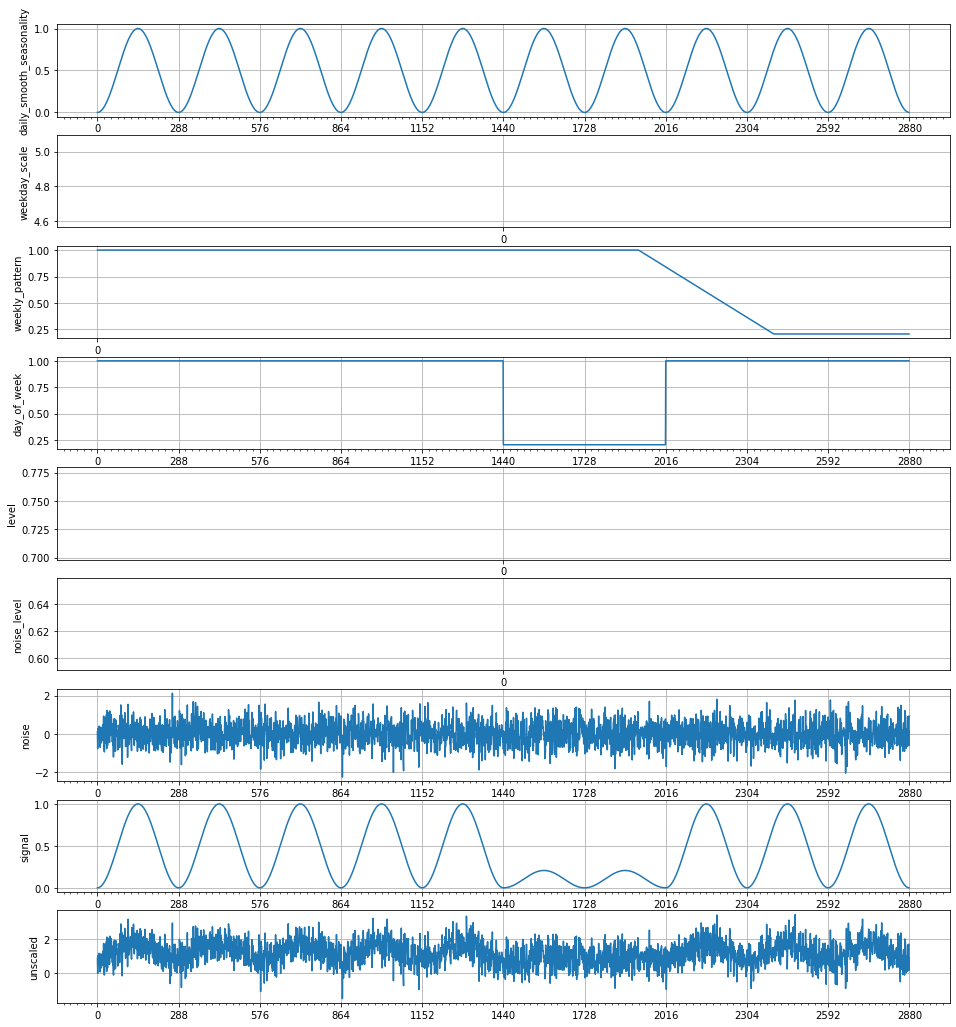

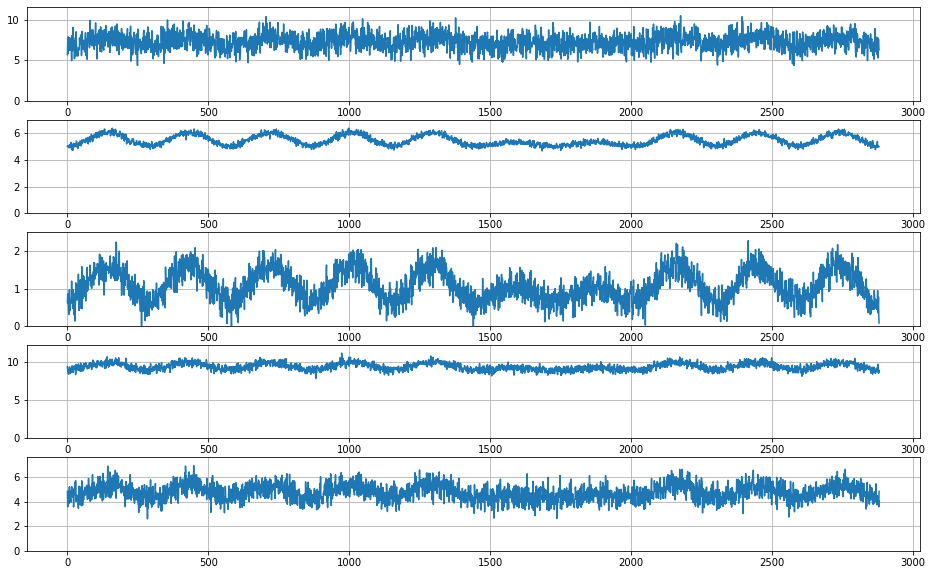

In [14]:
weekly_seasonal_unscaled = [
    ('daily_smooth_seasonality', rcp.SmoothSeasonality(period=288, phase=-72)),
    ('weekday_scale', rcp.RandomUniform(0.1, 10, shape=(1,))),
    ('weekly_pattern', rcp.NormalizeMax(rcp.Concatenate([rcp.Ref("weekday_scale") * np.ones(5), np.ones(2)]))),
    ('day_of_week', rcp.Dilated(rcp.Repeated('weekly_pattern'), 288)),
    ('level', rcp.RandomUniform(low=0, high=10, shape=1)),
    ('noise_level', rcp.RandomUniform(low=0.01, high=1, shape=1)),
    ('noise', 'noise_level' * rcp.RandomGaussian()),
    ('signal', rcp.Mul(['daily_smooth_seasonality','day_of_week'])),
    ('unscaled', rcp.Add(['level', 'signal', 'noise']))
]
     
plot_recipe(weekly_seasonal_unscaled, 10 * 288)
plot_examples(weekly_seasonal_unscaled, "unscaled", 10 * 288, 5)

## Composing Recipes

As recipes are just lists of expressions that evaluated sequentially, recipes can simply be composed from smaller component recipes by concatenating the corresponding lists. It is also possible to include the output of one recipe inside another one using the `EvalRecipe` operator.

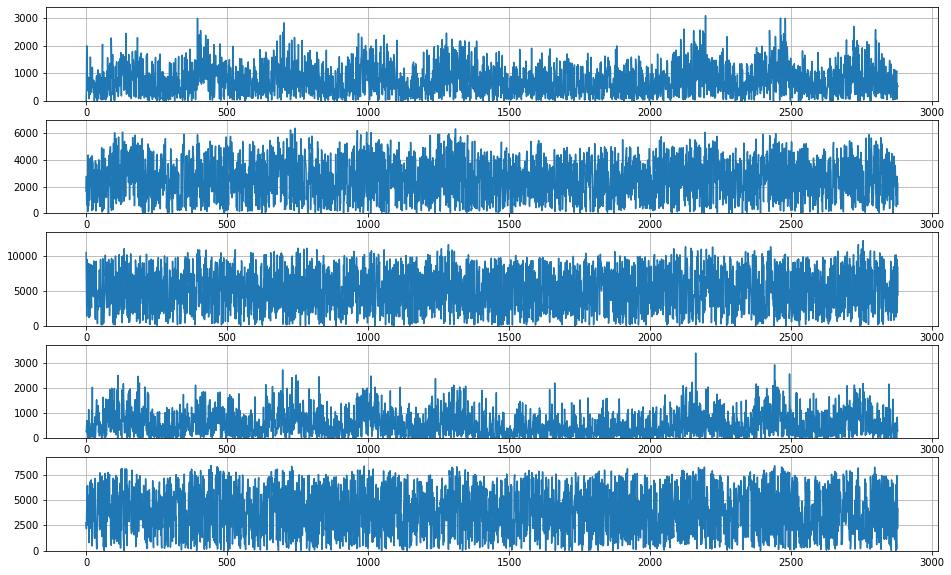

In [15]:
scaling = [
    ("scale", rcp.RandomUniform(0, 1000)),
    ("z", "scale" * rcp.Ref("unscaled"))
]

weekly_seasonal = weekly_seasonal_unscaled + scaling

plot_examples(weekly_seasonal, "z", 10 * 288, 5)

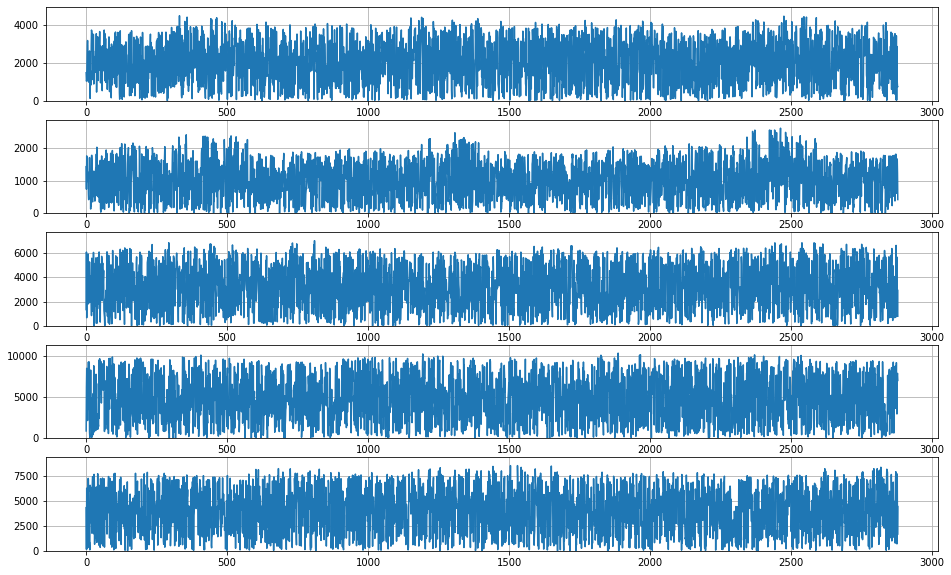

In [16]:
weekly_seasonality = [
    ('daily_pattern', rcp.RandomUniform(0, 1, shape=(24,))),
    ('daily_seasonality', rcp.Dilated(rcp.Repeated("daily_pattern"), 12)),
    ('weekly_pattern', rcp.RandomUniform(0, 1, shape=(7,))),
    ('weekly_seasonality', rcp.Dilated(rcp.Repeated("weekly_pattern"), 288)),
    ('unnormalized_seasonality', rcp.Mul(['daily_seasonality', 'weekly_seasonality'])),
    ('seasonality', rcp.NormalizeMax("unnormalized_seasonality")),
]

gaussian_noise_low = [
    ('noise_level', rcp.RandomUniform(low=0.01, high=0.1, shape=1)),
    ('noise', rcp.Ref('noise_level') * rcp.RandomGaussian()),
]

complex_weekly_seasonal = (
      weekly_seasonality 
    + [
        ('level', rcp.RandomUniform(low=0, high=10, shape=1)),
        ('signal', rcp.Add(['level', 'seasonality']))
    ]
    + gaussian_noise_low
    + [("unscaled", rcp.Add(["signal", "noise"]))]
    + scaling
)

plot_examples(complex_weekly_seasonal, "z", 10 * 288, 5)

## Generating Anomalies

Anomalies are just another effect added/multiplied to a base time series. We can define a recipe for creating certain types of anomalies, and then compose it with a base recipe.

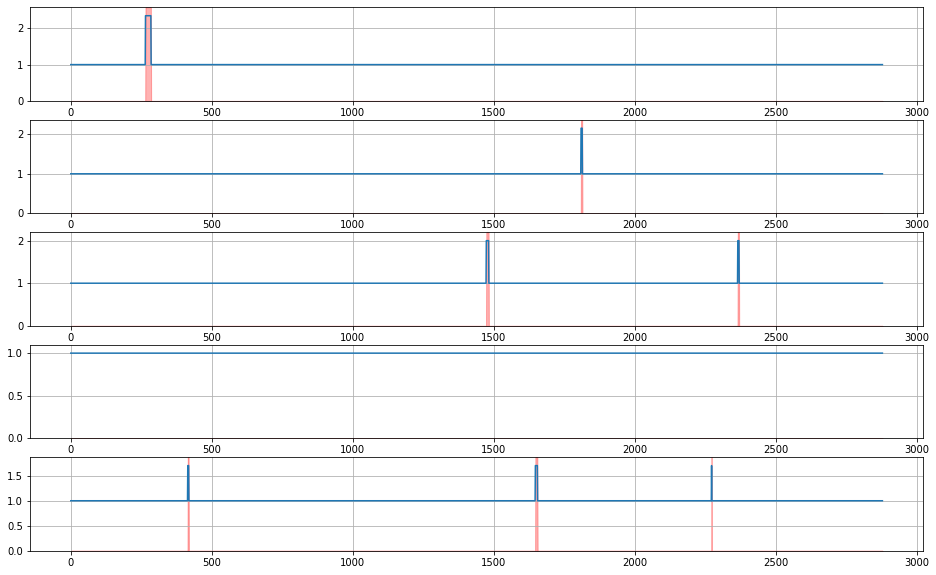

In [17]:
constant_recipe = [
    ("z", rcp.ConstantVec(1.0))
]

bmc_scale_anomalies = [
    ('normal_indicator', rcp.BinaryMarkovChain(one_to_zero=1/(288*7), zero_to_one=0.1)),
    ('anomaly_indicator', rcp.OneMinus('normal_indicator')),
    ('anomaly_scale', 0.5 + rcp.RandomUniform(-1.0, 1.0, shape=1)),
    ('anomaly_multiplier', 1 + rcp.Ref('anomaly_scale') * rcp.Ref('anomaly_indicator')),
    ('target', rcp.Mul(['z', 'anomaly_multiplier']))
]

plot_examples(constant_recipe + bmc_scale_anomalies, "target", 10*288, 5, "anomaly_indicator")

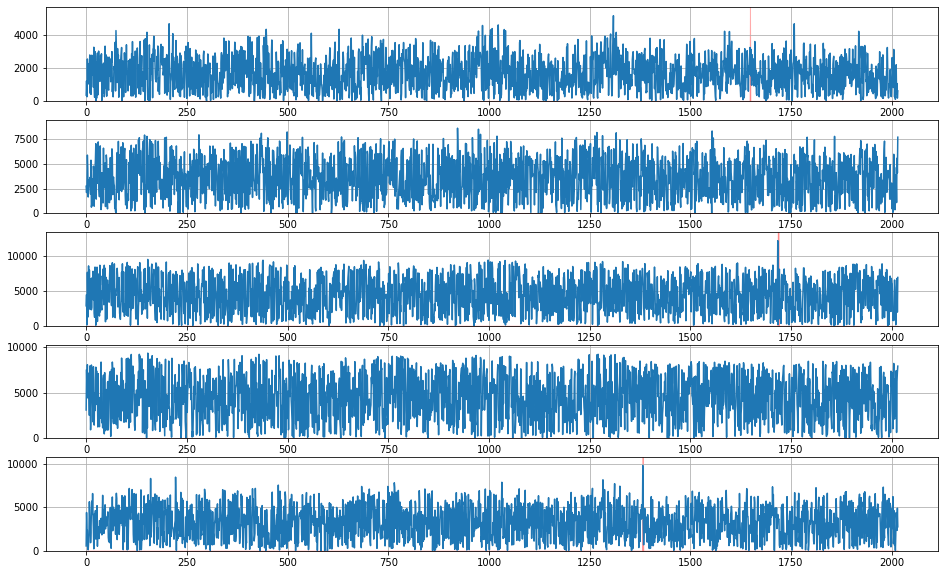

In [18]:
plot_examples(weekly_seasonal + bmc_scale_anomalies, 'target', 288*7, 5, "anomaly_indicator")

## Generating Changepoints

In [0]:
homoskedastic_gaussian_noise = [
    ('level', rcp.RandomUniform(0, 10, shape=1)),
    ('noise_level', rcp.RandomUniform(0.01, 1, shape=1)),
    ('noise', rcp.RandomGaussian("noise_level")),
    ('unscaled', rcp.Add(['level', 'noise'])), 
]

In [0]:
changepoint_noise_to_seasonal = [
    ('z_1', rcp.EvalRecipe(homoskedastic_gaussian_noise, "unscaled")), 
    ('z_2', rcp.EvalRecipe(weekly_seasonal_unscaled, "unscaled")),
    ('z_stacked', rcp.StackPrefix('z')),
    ('change', rcp.RandomChangepoints(1)),
    ('unscaled', rcp.Choose("z_stacked", "change"))
]

changepoint_noise_to_seasonal_scaled = changepoint_noise_to_seasonal + scaling

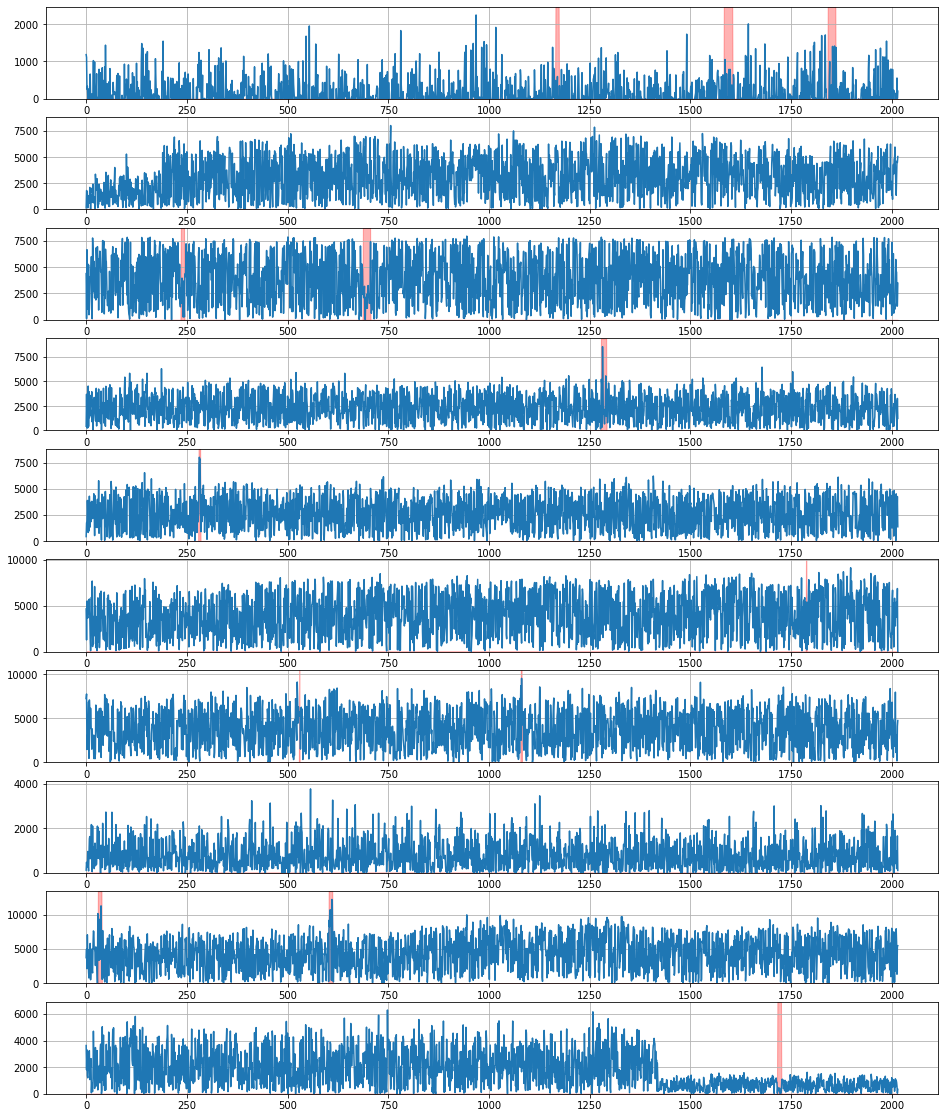

In [21]:
plot_examples(changepoint_noise_to_seasonal_scaled + bmc_scale_anomalies, 'target', 288*7, 10, "anomaly_indicator")

## Generating several time series

In [22]:
rcp.take_as_list(rcp.generate(10, weekly_seasonal_unscaled, "2018-01-01", {}), 2)

[{'daily_smooth_seasonality': array([0.        , 0.00011899, 0.00047589, 0.00107054, 0.00190265,
         0.00297183, 0.00427757, 0.00581924, 0.00759612, 0.00960736]),
  'day_of_week': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
  'item_id': '0',
  'level': array([7.15189366]),
  'noise': array([-1.37627579,  0.80910965, -0.5113108 ,  1.19522357,  0.76819937,
         -0.30693338,  1.54426428,  0.65576722,  0.29384949,  0.35138523]),
  'noise_level': array([0.60673574]),
  'signal': array([0.        , 0.00011899, 0.00047589, 0.00107054, 0.00190265,
         0.00297183, 0.00427757, 0.00581924, 0.00759612, 0.00960736]),
  'start': '2018-01-01',
  'unscaled': array([5.77561787, 7.9611223 , 6.64105875, 8.34818777, 7.92199568,
         6.84793212, 8.70043552, 7.81348013, 7.45333928, 7.51288625]),
  'weekday_scale': array([5.53325369]),
  'weekly_pattern': array([1.        , 1.        , 1.        , 1.        , 1.        ,
         0.18072549, 0.18072549])},
 {'daily_smooth_seasonality':

## Saving to a file

In [0]:
def write_to_file(recipe, length, num_ts, fields, fn):
    with open(fn, 'w') as f, open(fn+"-all", 'w') as g:
        for x in islice(rcp.generate(length, recipe, "2019-01-07 00:00"), num_ts):
            z = {}
            for k in x:
                if type(x[k]) == np.ndarray:
                    z[k] = x[k].tolist()
                else:
                    z[k] = x[k]
            xx = {}
            for fi in fields:
                xx[fi] = z[fi]
            try:
                f.write(json.dumps(xx))
            except Exception as e:
                print(xx)
                print(z)
                raise e
            f.write('\n')
            g.write(json.dumps(z))
            g.write('\n')